In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
# Om			\Omega_m
# Obh2			\Omega_{b}h^2
# h	
datafile = 'chains/LCDM_phy_HD_nested_dynesty_multi_1.txt'

In [4]:
class LoadDataSet(torch.utils.data.Dataset):
    '''
    Prepare the dataset for regression
    '''
    def __init__(self, X, y, scale_data=False):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary
            if scale_data:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [5]:
class MLP(nn.Module):
    '''
    Multilayer Perceptron for regression.
    '''
    def __init__(self):
        super().__init__()
        ncols = 3
        self.layers = nn.Sequential(
          nn.Linear(ncols, 200),
          nn.ReLU(),
          nn.Linear(200, 200),
          nn.ReLU(),
          nn.Linear(200, 1)
        )


    def forward(self, x):
        '''
          Forward pass
        '''
        return self.layers(x)

In [24]:
if __name__ == '__main__':
    # Set fixed random number seed
    torch.manual_seed(42)
  
    # Load Boston dataset
    X = np.loadtxt(datafile, usecols=(2,3,4))
    y = np.loadtxt(datafile, usecols=1).reshape(-1, 1)
    randomize = np.random.permutation(len(X))
    X = X[randomize]
    y = y[randomize]
    print(np.shape(X), np.shape(y))
    X_test, y_test = X[:100, :], y[:100, :]
    X, y = X[100:600, :], y[100:600, :]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    print(np.shape(X_train), np.shape(X_val))


(1036, 3) (1036, 1)
(400, 3) (100, 3)


In [25]:
dataset_train = LoadDataSet(X_train, y_train)
dataset_val = LoadDataSet(X_val, y_val)
# dataset_test = LoadDataSet(X_test, y_test)
X_test, y_test = torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

In [26]:
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=1, shuffle=True, num_workers=1)
validloader = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=True, num_workers=1)

In [27]:
# Initialize the MLP
mlp = MLP()
mlp.float()
# Define the loss function and optimizer
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

In [28]:
summary(mlp, batch_size=-1)

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       800
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       40,200
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       201
Total params: 41,201
Trainable params: 41,201
Non-trainable params: 0

In [29]:
# Run the training loop
history_train = np.empty((1,))
history_val = np.empty((1,))
nepochs=50
for epoch in range(0, nepochs): # 5 epochs at maximum  
    # Print epoch
    print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):

          # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 10 == 0:
            print('Loss after mini-batch %5d: %.3f' %
#                 (i + 1, current_loss / 500))
                  (i + 1, loss.item()))
            current_loss = 0.0
    history_train = np.append(history_train, current_loss)

    
    valid_loss = 0.0
    mlp.eval()     # Optional when not using Model Specific layer
    for i, data in enumerate(validloader, 0):
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
        
        output_val = mlp(inputs)
        valid_loss = loss_function(output_val, targets)
    
        valid_loss += loss.item()
    history_val = np.append(history_val, valid_loss.item())
    print('Training Loss: {:.3f} \t\t Validation Loss:'\
         '{:.3f}'.format(loss.item(), valid_loss.item()))
#     print('Training Loss: {:.3f} \t\t Validation Loss:'\
#           '{:.3f}'.format(current_loss / len(trainloader), valid_loss / len(validloader)))
#     if min_valid_loss > valid_loss:
#         print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
#         min_valid_loss = valid_loss
#         # Saving State Dict
#         torch.save(model.state_dict(), 'saved_model.pth')

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch     1: 43.468
Loss after mini-batch    11: 12.249
Loss after mini-batch    21: 8.199
Loss after mini-batch    31: 7.028
Loss after mini-batch    41: 7.697
Loss after mini-batch    51: 6.994
Loss after mini-batch    61: 7.762
Loss after mini-batch    71: 10.335
Loss after mini-batch    81: 8.519
Loss after mini-batch    91: 6.157
Loss after mini-batch   101: 5.873
Loss after mini-batch   111: 5.749
Loss after mini-batch   121: 6.025
Loss after mini-batch   131: 23.630
Loss after mini-batch   141: 19.197
Loss after mini-batch   151: 47.126
Loss after mini-batch   161: 5.268
Loss after mini-batch   171: 4.326
Loss after mini-batch   181: 6.877
Loss after mini-batch   191: 4.990
Loss after mini-batch   201: 3.982
Loss after mini-batch   211: 3.099
Loss after mini-batch   221: 8.234
Loss after mini-batch   231: 3.155
Loss after mini-batch   241: 1.927
Loss after mini-batch   251: 1.678
Loss after mini-batch   261: 1.805
Loss after mini-batch   271: 0.6

Loss after mini-batch   261: 0.565
Loss after mini-batch   271: 0.156
Loss after mini-batch   281: 1.368
Loss after mini-batch   291: 0.603
Loss after mini-batch   301: 0.714
Loss after mini-batch   311: 13.414
Loss after mini-batch   321: 0.739
Loss after mini-batch   331: 0.128
Loss after mini-batch   341: 0.250
Loss after mini-batch   351: 0.587
Loss after mini-batch   361: 0.647
Loss after mini-batch   371: 0.273
Loss after mini-batch   381: 0.598
Loss after mini-batch   391: 21.578
Training Loss: 22.872 		 Validation Loss:23.444
Starting epoch 7
Loss after mini-batch     1: 0.050
Loss after mini-batch    11: 0.815
Loss after mini-batch    21: 4.769
Loss after mini-batch    31: 0.793
Loss after mini-batch    41: 31.853
Loss after mini-batch    51: 0.819
Loss after mini-batch    61: 0.667
Loss after mini-batch    71: 0.781
Loss after mini-batch    81: 0.862
Loss after mini-batch    91: 0.823
Loss after mini-batch   101: 8.945
Loss after mini-batch   111: 0.544
Loss after mini-batch 

Loss after mini-batch   101: 0.522
Loss after mini-batch   111: 0.114
Loss after mini-batch   121: 1.401
Loss after mini-batch   131: 0.016
Loss after mini-batch   141: 15.105
Loss after mini-batch   151: 17.190
Loss after mini-batch   161: 19.636
Loss after mini-batch   171: 0.900
Loss after mini-batch   181: 0.072
Loss after mini-batch   191: 4.570
Loss after mini-batch   201: 0.318
Loss after mini-batch   211: 18.095
Loss after mini-batch   221: 0.150
Loss after mini-batch   231: 1.258
Loss after mini-batch   241: 0.769
Loss after mini-batch   251: 1.106
Loss after mini-batch   261: 0.866
Loss after mini-batch   271: 0.890
Loss after mini-batch   281: 5.440
Loss after mini-batch   291: 0.969
Loss after mini-batch   301: 4.839
Loss after mini-batch   311: 0.634
Loss after mini-batch   321: 1.439
Loss after mini-batch   331: 0.355
Loss after mini-batch   341: 0.836
Loss after mini-batch   351: 0.517
Loss after mini-batch   361: 0.014
Loss after mini-batch   371: 55.792
Loss after mini

Loss after mini-batch   351: 2.351
Loss after mini-batch   361: 2.070
Loss after mini-batch   371: 0.688
Loss after mini-batch   381: 0.618
Loss after mini-batch   391: 0.093
Training Loss: 0.422 		 Validation Loss:0.837
Starting epoch 18
Loss after mini-batch     1: 36.605
Loss after mini-batch    11: 0.563
Loss after mini-batch    21: 1.634
Loss after mini-batch    31: 0.177
Loss after mini-batch    41: 0.524
Loss after mini-batch    51: 0.644
Loss after mini-batch    61: 0.233
Loss after mini-batch    71: 15.115
Loss after mini-batch    81: 35.091
Loss after mini-batch    91: 55.343
Loss after mini-batch   101: 0.432
Loss after mini-batch   111: 0.090
Loss after mini-batch   121: 0.125
Loss after mini-batch   131: 0.228
Loss after mini-batch   141: 0.522
Loss after mini-batch   151: 31.319
Loss after mini-batch   161: 0.635
Loss after mini-batch   171: 0.586
Loss after mini-batch   181: 11.498
Loss after mini-batch   191: 0.608
Loss after mini-batch   201: 3.564
Loss after mini-batc

Loss after mini-batch   171: 1.178
Loss after mini-batch   181: 2.996
Loss after mini-batch   191: 0.603
Loss after mini-batch   201: 0.363
Loss after mini-batch   211: 0.632
Loss after mini-batch   221: 0.227
Loss after mini-batch   231: 0.616
Loss after mini-batch   241: 3.133
Loss after mini-batch   251: 2.911
Loss after mini-batch   261: 0.067
Loss after mini-batch   271: 6.826
Loss after mini-batch   281: 4.006
Loss after mini-batch   291: 5.438
Loss after mini-batch   301: 0.682
Loss after mini-batch   311: 11.187
Loss after mini-batch   321: 7.149
Loss after mini-batch   331: 0.533
Loss after mini-batch   341: 0.187
Loss after mini-batch   351: 0.615
Loss after mini-batch   361: 0.581
Loss after mini-batch   371: 54.674
Loss after mini-batch   381: 0.296
Loss after mini-batch   391: 0.688
Training Loss: 40.836 		 Validation Loss:41.210
Starting epoch 24
Loss after mini-batch     1: 0.168
Loss after mini-batch    11: 35.135
Loss after mini-batch    21: 0.252
Loss after mini-batch

Loss after mini-batch     1: 0.807
Loss after mini-batch    11: 0.790
Loss after mini-batch    21: 0.181
Loss after mini-batch    31: 0.157
Loss after mini-batch    41: 94.815
Loss after mini-batch    51: 0.377
Loss after mini-batch    61: 0.284
Loss after mini-batch    71: 14.784
Loss after mini-batch    81: 0.148
Loss after mini-batch    91: 0.190
Loss after mini-batch   101: 1.302
Loss after mini-batch   111: 3.370
Loss after mini-batch   121: 4.541
Loss after mini-batch   131: 0.464
Loss after mini-batch   141: 4.029
Loss after mini-batch   151: 0.603
Loss after mini-batch   161: 9.318
Loss after mini-batch   171: 0.428
Loss after mini-batch   181: 0.401
Loss after mini-batch   191: 0.460
Loss after mini-batch   201: 0.226
Loss after mini-batch   211: 16.511
Loss after mini-batch   221: 0.486
Loss after mini-batch   231: 1.876
Loss after mini-batch   241: 0.017
Loss after mini-batch   251: 1.695
Loss after mini-batch   261: 0.314
Loss after mini-batch   271: 0.202
Loss after mini-b

Loss after mini-batch   291: 0.341
Loss after mini-batch   301: 5.030
Loss after mini-batch   311: 53.953
Loss after mini-batch   321: 0.463
Loss after mini-batch   331: 3.912
Loss after mini-batch   341: 0.164
Loss after mini-batch   351: 0.778
Loss after mini-batch   361: 0.442
Loss after mini-batch   371: 0.360
Loss after mini-batch   381: 0.574
Loss after mini-batch   391: 0.316
Training Loss: 17.089 		 Validation Loss:17.463
Starting epoch 35
Loss after mini-batch     1: 2.233
Loss after mini-batch    11: 2.284
Loss after mini-batch    21: 0.323
Loss after mini-batch    31: 0.340
Loss after mini-batch    41: 0.314
Loss after mini-batch    51: 2.784
Loss after mini-batch    61: 0.485
Loss after mini-batch    71: 0.320
Loss after mini-batch    81: 0.481
Loss after mini-batch    91: 0.206
Loss after mini-batch   101: 0.284
Loss after mini-batch   111: 0.430
Loss after mini-batch   121: 0.244
Loss after mini-batch   131: 1.893
Loss after mini-batch   141: 13.537
Loss after mini-batch 

Loss after mini-batch   171: 0.529
Loss after mini-batch   181: 0.691
Loss after mini-batch   191: 0.485
Loss after mini-batch   201: 0.012
Loss after mini-batch   211: 0.645
Loss after mini-batch   221: 0.052
Loss after mini-batch   231: 0.492
Loss after mini-batch   241: 0.301
Loss after mini-batch   251: 0.019
Loss after mini-batch   261: 0.336
Loss after mini-batch   271: 0.791
Loss after mini-batch   281: 0.274
Loss after mini-batch   291: 0.260
Loss after mini-batch   301: 13.016
Loss after mini-batch   311: 44.237
Loss after mini-batch   321: 0.362
Loss after mini-batch   331: 0.271
Loss after mini-batch   341: 0.321
Loss after mini-batch   351: 0.647
Loss after mini-batch   361: 0.642
Loss after mini-batch   371: 41.703
Loss after mini-batch   381: 0.259
Loss after mini-batch   391: 0.132
Training Loss: 2.343 		 Validation Loss:2.709
Starting epoch 41
Loss after mini-batch     1: 0.429
Loss after mini-batch    11: 8.053
Loss after mini-batch    21: 2.005
Loss after mini-batch  

Loss after mini-batch     1: 0.155
Loss after mini-batch    11: 1.115
Loss after mini-batch    21: 5.763
Loss after mini-batch    31: 50.634
Loss after mini-batch    41: 0.572
Loss after mini-batch    51: 5.118
Loss after mini-batch    61: 0.535
Loss after mini-batch    71: 1.380
Loss after mini-batch    81: 55.021
Loss after mini-batch    91: 0.261
Loss after mini-batch   101: 0.509
Loss after mini-batch   111: 57.657
Loss after mini-batch   121: 0.342
Loss after mini-batch   131: 0.091
Loss after mini-batch   141: 0.436
Loss after mini-batch   151: 12.028
Loss after mini-batch   161: 0.156
Loss after mini-batch   171: 4.934
Loss after mini-batch   181: 0.081
Loss after mini-batch   191: 0.537
Loss after mini-batch   201: 0.009
Loss after mini-batch   211: 0.611
Loss after mini-batch   221: 0.516
Loss after mini-batch   231: 0.566
Loss after mini-batch   241: 4.482
Loss after mini-batch   251: 0.415
Loss after mini-batch   261: 0.250
Loss after mini-batch   271: 0.209
Loss after mini-

In [30]:
# test = np.random.randn(13)
# torch usa tensores de torch y no numpy.darrays
dtype = torch.float
test = torch.randn((1, 3), device=device, dtype=dtype)

In [31]:
y_pred = mlp.forward(X_test)

In [32]:
y_pred[0].item()

8.371753692626953

In [33]:
X_test[0, 0], X_test[0]
# xtest = [x[0] for x in X_test]
ypred = [y[0].item() for y in y_pred]
ytest = [y[0].item() for y in y_test]
diff=np.array(ytest)-np.array(ypred)
len(diff)

100

(0.0, 4.5)

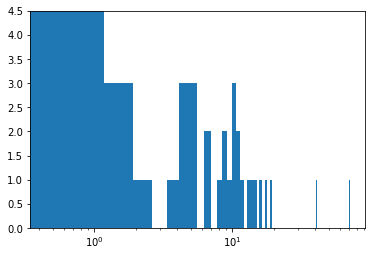

In [34]:
plt.hist(diff,bins=100)
plt.xscale('log')
plt.ylim(0,4.5)

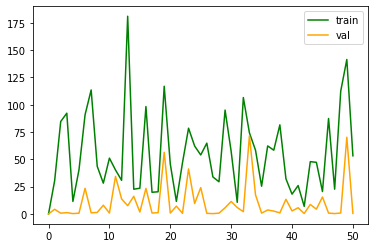

In [35]:
ep = np.arange(0, nepochs+1)
plt.plot(ep, history_train, label='train', color='green')
plt.plot(ep, history_val, label='val', color='orange')
plt.legend()

[87.23693] [16.030924]
[7.2511854] [7.2660136]


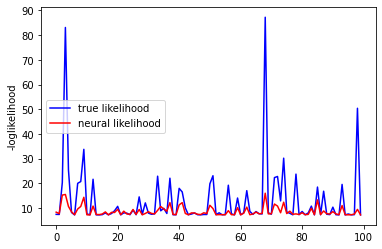

In [36]:
# sns.displot(y_test)
plt.plot(np.sort(y_test.detach().numpy()), color='blue', label='true likelihood')
plt.plot(np.sort(y_pred.detach().numpy()), color='red', label='neural likelihood')
plt.ylabel('-loglikelihood')
plt.legend()
print(max(y_test.detach().numpy()), max(y_pred.detach().numpy()))
print(min(y_test.detach().numpy()), min(y_pred.detach().numpy()))

In [37]:
np.shape(y_pred), np.shape(y_test), np.shape(y_pred.detach().numpy())

(torch.Size([100, 1]), torch.Size([100, 1]), (100, 1))

In [38]:
np.shape(history_train), np.shape(history_val)

((51,), (51,))

(0.0, 60.0)

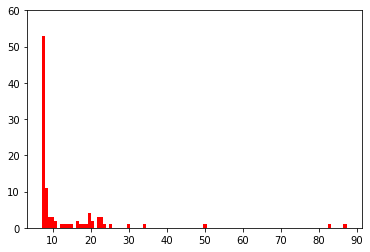

In [39]:
plt.hist(ytest, bins=len(ytest), color='red')
# plt.hist(ypred, bins=len(ypred), color='green')
plt.ylim(0,60)

In [40]:
len(ypred)==len(ytest)

True

In [41]:
len(ypred)

100

In [55]:
pred = map(mlp.forward, X_test)
for res in pred:
    print(type(res), res.item())

<class 'torch.Tensor'> 8.371753692626953
<class 'torch.Tensor'> 7.754067897796631
<class 'torch.Tensor'> 15.272122383117676
<class 'torch.Tensor'> 15.526750564575195
<class 'torch.Tensor'> 10.680397033691406
<class 'torch.Tensor'> 8.487668991088867
<class 'torch.Tensor'> 7.3282670974731445
<class 'torch.Tensor'> 9.643688201904297
<class 'torch.Tensor'> 10.67636489868164
<class 'torch.Tensor'> 14.384824752807617
<class 'torch.Tensor'> 7.302188396453857
<class 'torch.Tensor'> 7.273252487182617
<class 'torch.Tensor'> 10.827005386352539
<class 'torch.Tensor'> 7.436983108520508
<class 'torch.Tensor'> 7.379617214202881
<class 'torch.Tensor'> 7.6102681159973145
<class 'torch.Tensor'> 8.467998504638672
<class 'torch.Tensor'> 7.266648769378662
<class 'torch.Tensor'> 8.279807090759277
<class 'torch.Tensor'> 8.23650074005127
<class 'torch.Tensor'> 9.531845092773438
<class 'torch.Tensor'> 7.351142406463623
<class 'torch.Tensor'> 8.762679100036621
<class 'torch.Tensor'> 7.62294864654541
<class 'tor